In [1]:
# Read Image
import numpy as np
import skimage
Xi = skimage.io.imread("To_Matrix_test.png")
Xi = skimage.transform.resize(Xi, (299,299)) 
Xi = (Xi - 0.5)*2 #Inception pre-processing
skimage.io.imshow(Xi/2+0.5) # Show image before inception preprocessing

#Predict class for image using InceptionV3
import keras
from keras.applications.imagenet_utils import decode_predictions
np.random.seed(222)
inceptionV3_model = keras.applications.inception_v3.InceptionV3() #Load pretrained model
preds = inceptionV3_model.predict(Xi[np.newaxis,:,:,:])
top_pred_classes = preds[0].argsort()[-5:][::-1] # Save ids of top 5 classes
decode_predictions(preds)[0] #Print top 5 classes

Using TensorFlow backend.


[('n03877472', 'pajama', 0.0897184),
 ('n04350905', 'suit', 0.035495754),
 ('n02883205', 'bow_tie', 0.033729058),
 ('n02769748', 'backpack', 0.031381227),
 ('n02815834', 'beaker', 0.026813142)]

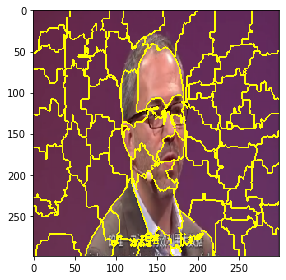

In [2]:
#Generate segmentation for image
import skimage.segmentation
superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi/2+0.5, superpixels))

In [3]:
num_superpixels

62

[1 0 0 1 0 0 1 0 1 0 1 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 1 0 1
 0 1 0 1 0 1 0 1 1 0 0 0 1 1 0 1 0 0 0 1 1 1 1 1 1]


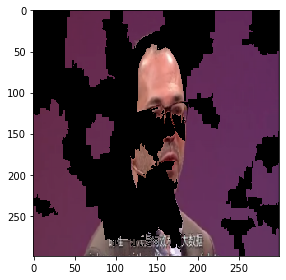

In [4]:
#Generate perturbations
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))

#Create function to apply perturbations to images
import copy
def perturb_image(img,perturbation,segments): 
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image

#Show example of perturbations
print(perturbations[0]) 
skimage.io.imshow(perturb_image(Xi/2+0.5,perturbations[0],superpixels))

In [5]:
predictions = []
for pert in perturbations:
  perturbed_img = perturb_image(Xi,pert,superpixels)
  pred = inceptionV3_model.predict(perturbed_img[np.newaxis,:,:,:])
  predictions.append(pred)

predictions = np.array(predictions)
print(predictions.shape)

(150, 1, 1000)


In [6]:
#Compute distances to original image
import sklearn.metrics
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
print(distances.shape)

#Transform distances to a value between 0 an 1 (weights) using a kernel function
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
print(weights.shape)

(150,)
(150,)


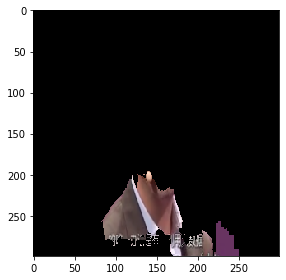

In [7]:
#Estimate linear model
from sklearn.linear_model import LinearRegression
class_to_explain = top_pred_classes[0] #Labrador class
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]

#Use coefficients from linear model to extract top features
num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 

#Show only the superpixels corresponding to the top features
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels))

In [8]:
predictions = []
for pert in perturbations:
  perturbed_img = perturb_image(Xi,pert,superpixels)
  pred = inceptionV3_model.predict(perturbed_img[np.newaxis,:,:,:])
  predictions.append(pred)

predictions = np.array(predictions)
predictions.shape

(150, 1, 1000)

In [9]:
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
distances.shape

(150,)

In [10]:
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
weights.shape

(150,)

In [11]:
class_to_explain = top_pred_classes[0]
simpler_model = LinearRegression()                                                             #每個perturbation視作一個sample, 每個perturbation是一個62維的data point
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights) #sample_weight是給每個perturbation, 共150個
coeff = simpler_model.coef_[0]
coeff

array([ 0.00513199, -0.00309965, -0.00514841, -0.00942514, -0.00036398,
        0.00407407,  0.00352418,  0.00619566, -0.00482756,  0.00051557,
        0.00601808,  0.00614978,  0.00230708,  0.00339905,  0.00355371,
       -0.0044495 ,  0.00204945,  0.00065389,  0.00052517,  0.00073624,
       -0.00682805, -0.00446657, -0.00015651, -0.00106407, -0.00754908,
        0.00373838,  0.00081048,  0.0008008 ,  0.00426654,  0.00330621,
       -0.00511471, -0.00545022, -0.00437824, -0.00302599, -0.00446339,
       -0.00016888, -0.00062151,  0.00154246,  0.00146134,  0.0002021 ,
        0.00192209,  0.00431814, -0.002324  , -0.00692051, -0.00142599,
       -0.00234395, -0.00835299,  0.01600943, -0.00927375,  0.00627026,
        0.00346421, -0.01042625,  0.0070225 ,  0.01123226,  0.01268834,
        0.0055808 ,  0.0122441 ,  0.00224955, -0.00246851,  0.00586408,
        0.00848683, -0.00326012])

In [12]:
simpler_model.coef_

array([[ 0.00513199, -0.00309965, -0.00514841, -0.00942514, -0.00036398,
         0.00407407,  0.00352418,  0.00619566, -0.00482756,  0.00051557,
         0.00601808,  0.00614978,  0.00230708,  0.00339905,  0.00355371,
        -0.0044495 ,  0.00204945,  0.00065389,  0.00052517,  0.00073624,
        -0.00682805, -0.00446657, -0.00015651, -0.00106407, -0.00754908,
         0.00373838,  0.00081048,  0.0008008 ,  0.00426654,  0.00330621,
        -0.00511471, -0.00545022, -0.00437824, -0.00302599, -0.00446339,
        -0.00016888, -0.00062151,  0.00154246,  0.00146134,  0.0002021 ,
         0.00192209,  0.00431814, -0.002324  , -0.00692051, -0.00142599,
        -0.00234395, -0.00835299,  0.01600943, -0.00927375,  0.00627026,
         0.00346421, -0.01042625,  0.0070225 ,  0.01123226,  0.01268834,
         0.0055808 ,  0.0122441 ,  0.00224955, -0.00246851,  0.00586408,
         0.00848683, -0.00326012]])

In [13]:
coeff.shape

(62,)

In [14]:
simpler_model.coef_.shape

(1, 62)

In [15]:
perturbations.shape

(150, 62)

In [18]:
Xi  #as input of the pre-trained model

array([[[-0.24078956, -0.70196078, -0.46824054],
        [-0.24705882, -0.70196078, -0.4745098 ],
        [-0.24705882, -0.70980392, -0.4745098 ],
        ...,
        [-0.2627451 , -0.68627451, -0.31764706],
        [-0.27058824, -0.69411765, -0.3254902 ],
        [-0.41952915, -0.75526264, -0.46189258]],

       [[-0.24078956, -0.70196078, -0.46824054],
        [-0.24705882, -0.70196078, -0.4745098 ],
        [-0.24705882, -0.70980392, -0.4745098 ],
        ...,
        [-0.2627451 , -0.68627451, -0.31764706],
        [-0.27058824, -0.69411765, -0.3254902 ],
        [-0.41952915, -0.75526264, -0.46189258]],

       [[-0.24078956, -0.70196078, -0.46824054],
        [-0.24705882, -0.70196078, -0.4745098 ],
        [-0.24705882, -0.70980392, -0.4745098 ],
        ...,
        [-0.2627451 , -0.68627451, -0.31764706],
        [-0.27058824, -0.69411765, -0.3254902 ],
        [-0.41952915, -0.75526264, -0.46189258]],

       ...,

       [[-0.2       , -0.62352941, -0.40392157],
        [-0

In [19]:
image = Xi/2+0.5  #as a image = 0-1
image

array([[[0.37960522, 0.14901961, 0.26587973],
        [0.37647059, 0.14901961, 0.2627451 ],
        [0.37647059, 0.14509804, 0.2627451 ],
        ...,
        [0.36862745, 0.15686275, 0.34117647],
        [0.36470588, 0.15294118, 0.3372549 ],
        [0.29023543, 0.12236868, 0.26905371]],

       [[0.37960522, 0.14901961, 0.26587973],
        [0.37647059, 0.14901961, 0.2627451 ],
        [0.37647059, 0.14509804, 0.2627451 ],
        ...,
        [0.36862745, 0.15686275, 0.34117647],
        [0.36470588, 0.15294118, 0.3372549 ],
        [0.29023543, 0.12236868, 0.26905371]],

       [[0.37960522, 0.14901961, 0.26587973],
        [0.37647059, 0.14901961, 0.2627451 ],
        [0.37647059, 0.14509804, 0.2627451 ],
        ...,
        [0.36862745, 0.15686275, 0.34117647],
        [0.36470588, 0.15294118, 0.3372549 ],
        [0.29023543, 0.12236868, 0.26905371]],

       ...,

       [[0.4       , 0.18823529, 0.29803922],
        [0.4       , 0.18823529, 0.29803922],
        [0.4       , 0

In [20]:
perturb_image(Xi/2+0.5,mask,superpixels)

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

In [21]:
perturb_image(Xi/2+0.5,mask,superpixels).shape

(299, 299, 3)

In [22]:
superpixels

array([[ 2,  2,  2, ...,  9,  9,  9],
       [ 2,  2,  2, ...,  9,  9,  9],
       [ 2,  2,  2, ...,  9,  9,  9],
       ...,
       [50, 50, 50, ..., 57, 57, 57],
       [50, 50, 50, ..., 57, 57, 57],
       [50, 50, 50, ..., 57, 57, 57]], dtype=int64)

In [36]:
def perturb_image2(mask, segments): 
  active_pixels = top_features
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  return mask

C = perturb_image2(mask, superpixels)
D = np.int64(C)
D

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

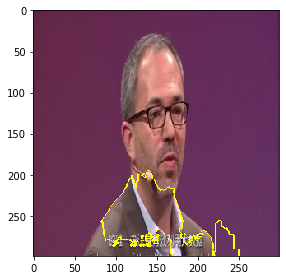

In [37]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi/2+0.5, D))

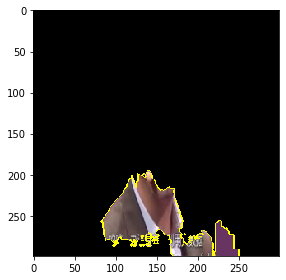

In [25]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(perturb_image(Xi/2+0.5,mask,superpixels), D))

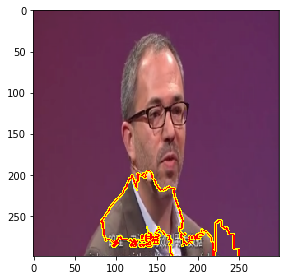

In [33]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi/2+0.5, D, color=(1, 0, 0), outline_color=(1, 1, 0)))

In [56]:
Xi

array([[[-0.24078956, -0.70196078, -0.46824054],
        [-0.24705882, -0.70196078, -0.4745098 ],
        [-0.24705882, -0.70980392, -0.4745098 ],
        ...,
        [-0.2627451 , -0.68627451, -0.31764706],
        [-0.27058824, -0.69411765, -0.3254902 ],
        [-0.41952915, -0.75526264, -0.46189258]],

       [[-0.24078956, -0.70196078, -0.46824054],
        [-0.24705882, -0.70196078, -0.4745098 ],
        [-0.24705882, -0.70980392, -0.4745098 ],
        ...,
        [-0.2627451 , -0.68627451, -0.31764706],
        [-0.27058824, -0.69411765, -0.3254902 ],
        [-0.41952915, -0.75526264, -0.46189258]],

       [[-0.24078956, -0.70196078, -0.46824054],
        [-0.24705882, -0.70196078, -0.4745098 ],
        [-0.24705882, -0.70980392, -0.4745098 ],
        ...,
        [-0.2627451 , -0.68627451, -0.31764706],
        [-0.27058824, -0.69411765, -0.3254902 ],
        [-0.41952915, -0.75526264, -0.46189258]],

       ...,

       [[-0.2       , -0.62352941, -0.40392157],
        [-0

In [55]:
image

array([[[0.37960522, 0.14901961, 0.26587973],
        [0.37647059, 0.14901961, 0.2627451 ],
        [0.37647059, 0.14509804, 0.2627451 ],
        ...,
        [0.36862745, 0.15686275, 0.34117647],
        [0.36470588, 0.15294118, 0.3372549 ],
        [0.29023543, 0.12236868, 0.26905371]],

       [[0.37960522, 0.14901961, 0.26587973],
        [0.37647059, 0.14901961, 0.2627451 ],
        [0.37647059, 0.14509804, 0.2627451 ],
        ...,
        [0.36862745, 0.15686275, 0.34117647],
        [0.36470588, 0.15294118, 0.3372549 ],
        [0.29023543, 0.12236868, 0.26905371]],

       [[0.37960522, 0.14901961, 0.26587973],
        [0.37647059, 0.14901961, 0.2627451 ],
        [0.37647059, 0.14509804, 0.2627451 ],
        ...,
        [0.36862745, 0.15686275, 0.34117647],
        [0.36470588, 0.15294118, 0.3372549 ],
        [0.29023543, 0.12236868, 0.26905371]],

       ...,

       [[0.4       , 0.18823529, 0.29803922],
        [0.4       , 0.18823529, 0.29803922],
        [0.4       , 0

In [71]:
from lime import lime_image
import time

In [72]:
explainer = lime_image.LimeImageExplainer()

In [74]:
explanation = explainer.explain_instance(Xi[np.newaxis,:,:,:], inceptionV3_model.predict, top_labels=5, hide_color=0, num_samples=1000)

RuntimeError: sequence argument must have length equal to input rank

In [81]:
tmp = time.time()
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(Xi, inceptionV3_model.predict, top_labels=5, hide_color=0, num_samples=1000)
print(time.time() - tmp)


551.0391833782196


In [82]:
Xi.shape #直接餵給inceptionV3_model.predict需要(batch_size, 299, 299, 3) = Xi[np.newaxis,:,:,:]
         #餵給explainer.explain_instance只需(299, 299, 3) = Xi (非0-1 or 0-255)

(299, 299, 3)

In [83]:
from skimage.segmentation import mark_boundaries

In [87]:
#when you call get_image_and_mask, the first parameter is which label you want the explanation for. 
#Since you called explain_instance with top_labels=5, 
#explanation only has the 5 labels with highest predicted probability by the model, 
#and I'm guessing 295 (American black bear) is not one of them.
top_pred_classes[0]

697

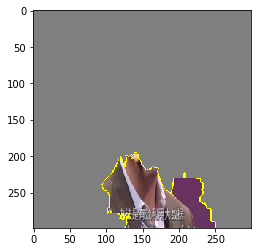

In [88]:
temp, mask = explanation.get_image_and_mask(top_pred_classes[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

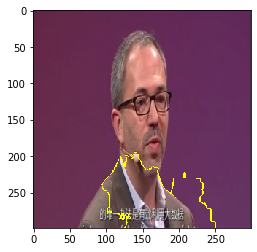

In [89]:
temp, mask = explanation.get_image_and_mask(top_pred_classes[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

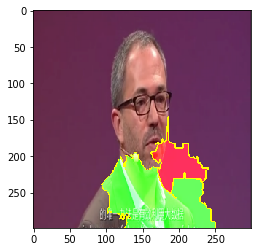

In [106]:
temp, mask = explanation.get_image_and_mask(top_pred_classes[0], positive_only=False, num_features=6, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

#Does this mean the 6th feature might not be good for predicting top_pred_classes[0]? After that (including it), all are not good?

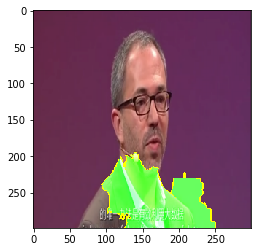

In [112]:
temp, mask = explanation.get_image_and_mask(top_pred_classes[0], positive_only=False, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

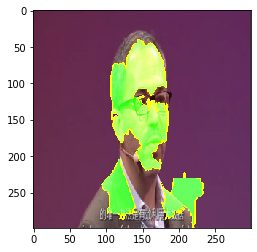

In [113]:
temp, mask = explanation.get_image_and_mask(top_pred_classes[1], positive_only=False, num_features=7, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

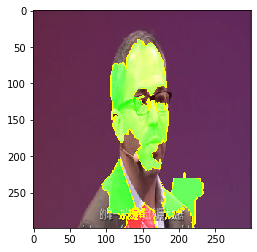

In [110]:
temp, mask = explanation.get_image_and_mask(top_pred_classes[1], positive_only=False, num_features=8, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

#Does this mean the 8th feature might not be good for predicting top_pred_classes[1]? After that (including it), all are not good?